In [5]:
#a wide array of techniques have been developed for visualizing and interpreting these representations. 
#We won't survey all of them, but we will cover three of the most accessible and useful ones:V

#isualizing intermediate convnet outputs ("intermediate activations"). This is useful to understand how successive convnet layers transform their input, and to get a first idea of the meaning of individual convnet filters.
#Visualizing convnets filters. This is useful to understand precisely what visual pattern or concept each filter in a convnet is receptive to.
#Visualizing heatmaps of class activation in an image. This is useful to understand which part of an image were identified as belonging to a given class, and thus allows to localize objects in images.

In [6]:
#This example just covers the 3rd one - 5.4.3:isualizing heatmaps of class activation in an image. This is useful to understand which part of an image were identified as belonging to a given class, and thus allows to localize objects in images.
# Note that we are including the densely-connected classifier on top;
# all previous times, we were discarding it.
#using the pre-trained VGG16 network again
print("Hi")

import keras
from keras import backend as K

from keras.applications.vgg16 import VGG16
K.clear_session()
model = VGG16(weights='imagenet')

Hi


In [7]:
from keras.preprocessing import image
from keras.applications.vgg16 import preprocess_input, decode_predictions
import numpy as np

# The local path to our target image
img_path = '/home/oj/Downloads/creative_commons_elephant.jpg'

# `img` is a PIL image of size 224x224
img = image.load_img(img_path, target_size=(224, 224))

# `x` is a float32 Numpy array of shape (224, 224, 3)
x = image.img_to_array(img)

# We add a dimension to transform our array into a "batch"
# of size (1, 224, 224, 3)
x = np.expand_dims(x, axis=0)

# Finally we preprocess the batch
# (this does channel-wise color normalization)
x = preprocess_input(x)

In [8]:
preds = model.predict(x)
print('Predicted:', decode_predictions(preds, top=3)[0])

Predicted: [('n02504458', 'African_elephant', 0.9094213), ('n01871265', 'tusker', 0.08618258), ('n02504013', 'Indian_elephant', 0.004354576)]


In [9]:
np.argmax(preds[0])
#Thus our network has recognized our image as containing an undetermined quantity of African elephants. 
#The entry in the prediction vector that was maximally activated is the one corresponding to the "African elephant" class, 
#at index 386:

386

In [10]:
#To visualize which parts of our image were the most "African elephant"-like, let's set up the Grad-CAM process:
# This is the "african elephant" entry in the prediction vector
african_elephant_output = model.output[:, 386]

# The is the output feature map of the `block5_conv3` layer,
# the last convolutional layer in VGG16
last_conv_layer = model.get_layer('block5_conv3')

# This is the gradient of the "african elephant" class with regard to
# the output feature map of `block5_conv3`
grads = K.gradients(african_elephant_output, last_conv_layer.output)[0]

# This is a vector of shape (512,), where each entry
# is the mean intensity of the gradient over a specific feature map channel
pooled_grads = K.mean(grads, axis=(0, 1, 2))

# This function allows us to access the values of the quantities we just defined:
# `pooled_grads` and the output feature map of `block5_conv3`,
# given a sample image
iterate = K.function([model.input], [pooled_grads, last_conv_layer.output[0]])

# These are the values of these two quantities, as Numpy arrays,
# given our sample image of two elephants
pooled_grads_value, conv_layer_output_value = iterate([x])

# We multiply each channel in the feature map array
# by "how important this channel is" with regard to the elephant class
for i in range(512):
    conv_layer_output_value[:, :, i] *= pooled_grads_value[i]

# The channel-wise mean of the resulting feature map
# is our heatmap of class activation
heatmap = np.mean(conv_layer_output_value, axis=-1)

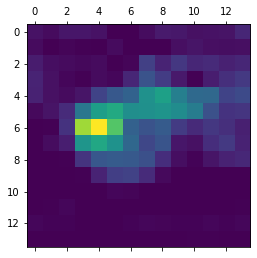

In [11]:
#For visualization purpose, we will also normalize the heatmap between 0 and 1:
import matplotlib.pyplot as plt

heatmap = np.maximum(heatmap, 0)
heatmap /= np.max(heatmap)
plt.matshow(heatmap)
plt.show()

In [ ]:
#Finally, we will use OpenCV to generate an image that superimposes the original image with the heatmap we just obtained:
import cv2

# We use cv2 to load the original image
img = cv2.imread(img_path)

# We resize the heatmap to have the same size as the original image
heatmap = cv2.resize(heatmap, (img.shape[1], img.shape[0]))

# We convert the heatmap to RGB
heatmap = np.uint8(255 * heatmap)

# We apply the heatmap to the original image
heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)

# 0.4 here is a heatmap intensity factor
superimposed_img = heatmap * 0.4 + img


# Save the image to disk
cv2.imwrite('/home/oj/Downloads/elephant_cam.jpg', superimposed_img)